# Exercise 4.1

Suppose that instead of observing coin tosses directly, you measure the outcome using an instrument that is not always correct. Specifically, suppose there is a probability y that an actual heads is reported as tails, or actual tails reported as heads.

Write a class that estimates the bias of a coin given a series of outcomes and the value of y.
How does the spread of the posterior distribution depend on y?

### Theory

We are tasked to find the probability of different hypothesis $H$ where the coin can land head with probability $x$ and tail with probability $1-x$. Let's first start from the basics.

- I will denote $H_x$ to be the hypothesis that head has a probability $x$
- $f_i$ will be the result of the i-th flip of the coin

$$P(H_x|f_1)=\frac{P(f_1|H_x)P(H_x)}{P(f_1)}$$

As stated in the chapter, our (simple) prior is just a uniform distribution between 0% and 100%. Once we flip the coin a second time, we can use our old posterior as our new prior.

$$P(H_x|f_1f_2)=\frac{P(f_1f_2H_x)}{P(f_1f_2)}=\frac{P(f_2|f_1H_x)P(H_x|f_1)P(f_1)}{P(f_1f_2)}$$

$$P(f_1f_2)=\sum{P(f_2|f_1H_x)P(H_x|f_1)P(f_1)}$$

$P(f_1)$ gets eliminated in the numerator and denominator

$$(H_x|f_1f_2)=\frac{P(f_2|f_1H_x)P(H_x|f_1)}{\sum{P(f_2|f_1H_i)P(H_i|f_1)}}$$

As we keep on flipping the coin, we can just update our belief about a certain hypothesis by continually using our posterior as the new prior, thus carying our knowledge about the coin.

----

#### Batch update

Let's say we already flipped the coin many times, can we do all the updates in one pass instead of looping through updates?

$$P(H_x|\textbf{F}) = \frac{P(\textbf{F}|H_x)P(H_x)}{P(\textbf{F})}$$
Where $\textbf{F}$ represents all the flips.

$P(\textbf{F}|H_x)$ follows a binomial distribution ${n_{heads}+n_{tails} \choose n_{heads}}P(head|H_x)^{n_{heads}}P(tail|H_x)^{n_{tails}}$

So the posterior can be calculated directly with
$$P(H_x|\textbf{F}) = \frac{{n_{heads}+n_{tails} \choose n_{heads}}P(head|H_x)^{n_{heads}}P(tail|H_x)^{n_{tails}}P(H_x)}{\sum_i{{n_{heads}+n_{tails} \choose n_{heads}}P(head|H_i)^{n_{heads}}P(tail|H_i)^{n_{tails}}P(H_i)}} \\  
= \frac{P(head|H_x)^{n_{heads}}P(tail|H_x)^{n_{tails}}P(H_x)}{\sum_i{P(head|H_i)^{n_{heads}}P(tail|H_i)^{n_{tails}}P(H_i)}}
$$

---

The probability of flipping head under the hypothesis $H_x$, the likelihood, is, normally, $x/100$. But we have an unreliable sensor that reports the right result with a probability $y$. So what is the probability of seeing *head* with that sensor? It's that it reports *head* when it really is and reports *head* again when it should have been *tail*.

$$P(f_1=head|H_x)=\frac{xy}{100}+\frac{(100-x)(100-y)}{100}=\frac{2xy+100-x-y}{100}$$

$$P(f_1=tail|H_x)=\frac{(100-x)y}{100}+\frac{x(100-y)}{100}=\frac{y-2xy+x}{100}$$

Summing both probabilities should give 1

$$P(f_1=head|H_x)+P(f_1=tail|H_x)=\frac{2xy+1-x-y}{100}+\frac{y-2xy+x}{100}=\frac{y-2xy+x+2xy+100-x-y}{100}\frac{100}{100}=1$$

So for this exercise it is just a matter of using this likelihood with the imperfect sensor.

### Pratice

It is just a matter of changing the likelihood function to use that uncertainty about the obervation and change the code a little bit to pass that information over.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'code'))

In [3]:
# %load code/euro.py
"""
This code was originally created by Allen B. Downey 
for "Think Bayes" and subsequently modified by me 
for the purpose of this exercise.
"""

from __future__ import print_function, division

"""This file contains a partial solution to a problem from
MacKay, "Information Theory, Inference, and Learning Algorithms."

    Exercise 3.15 (page 50): A statistical statement appeared in
    "The Guardian" on Friday January 4, 2002:

        When spun on edge 250 times, a Belgian one-euro coin came
        up heads 140 times and tails 110.  'It looks very suspicious
        to me,' said Barry Blight, a statistics lecturer at the London
        School of Economics.  'If the coin were unbiased, the chance of
        getting a result as extreme as that would be less than 7%.'

MacKay asks, "But do these data give evidence that the coin is biased
rather than fair?"

"""

import thinkbayes2
import thinkplot


class Euro(thinkbayes2.Suite):
    """Represents hypotheses about the probability of heads."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: integer value of x, the probability of heads (0-100)
        data: string 'H' or 'T'
        """
        data, y = data
        x = hypo*y / 10000.0 + (100-hypo)*(100-y) / 10000.0
        if data == 'H':
            return x
        else:
            return 1-x


class Euro2(thinkbayes2.Suite):
    """Represents hypotheses about the probability of heads."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: integer value of x, the probability of heads (0-100)
        data: tuple of (number of heads, number of tails)
        """
        data, y = data
        x = hypo*y / 10000.0 + (100-hypo)*(100-y) / 10000.0
        heads, tails = data
        like = x**heads * (1-x)**tails
        return like


def UniformPrior():
    """Makes a Suite with a uniform prior."""
    suite = Euro(range(0, 101))
    return suite


def TrianglePrior():
    """Makes a Suite with a triangular prior."""
    suite = Euro()
    for x in range(0, 51):
        suite.Set(x, x)
    for x in range(51, 101):
        suite.Set(x, 100-x) 
    suite.Normalize()
    return suite


def RunUpdate(suite, heads=140, tails=110, y=80):
    """Updates the Suite with the given number of heads and tails.

    suite: Suite object
    heads: int
    tails: int
    y: Probability of getting the right answer
    """
    dataset = 'H' * heads + 'T' * tails

    for data in dataset:
        suite.Update((data,y))


def Summarize(suite):
    """Prints summary statistics for the suite."""
    print(suite.Prob(50))

    print('MLE', suite.MaximumLikelihood())

    print('Mean', suite.Mean())
    print('Median', suite.Percentile(50)) 

    print('5th %ile', suite.Percentile(5)) 
    print('95th %ile', suite.Percentile(95)) 

    print('CI', suite.CredibleInterval(90))


def PlotSuites(suites, root):
    """Plots two suites.

    suite1, suite2: Suite objects
    root: string filename to write
    """
    thinkplot.Clf()
    thinkplot.PrePlot(len(suites))
    thinkplot.Pmfs(suites)

    thinkplot.Save(root=root,
                   xlabel='x',
                   ylabel='Probability',
                   formats=['pdf', 'eps'])


def main():
    # make the priors
    suite1 = UniformPrior()
    suite1.name = 'uniform'

    suite2 = TrianglePrior()
    suite2.name = 'triangle'

    # plot the priors
    PlotSuites([suite1, suite2], 'euro2')

    # update
    RunUpdate(suite1, y=90)
    Summarize(suite1)

    RunUpdate(suite2)
    Summarize(suite2)

    # plot the posteriors
    PlotSuites([suite1], 'euro1')
    PlotSuites([suite1, suite2], 'euro3')


In [4]:
main()

/Users/alexis/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Writing euro2.pdf
Writing euro2.eps
0.01678122090363576
MLE 57
Mean 57.440476190476176
Median 57
5th %ile 51
95th %ile 64
CI (51, 64)
0.015746638953007378
MLE 59
Mean 59.28301310013047
Median 59
5th %ile 51
95th %ile 68
CI (51, 68)
Writing euro1.pdf
Writing euro1.eps
Writing euro3.pdf
Writing euro3.eps


### Next

If a sensor is used to report the flip, we might not know its exact bias. It's highly unlikely that it reports the right answer only 1% of the time and more likely that it's okay 100%. To account for that we could make a mixture of distributions with $PMF(y) \propto \left(\frac{y}{100}\right)^\alpha$

# Exercise 4.2

This exercise is inspired by a question posted by a “redditor” named dominosci on Reddit’s statistics “subreddit” at http://reddit.com/r/statistics.

Reddit is an online forum with many interest groups called subreddits. Users, called redditors, post links to online content and other web pages. Other redditors vote on the links, giving an “upvote” to high-quality links and a “downvote” to links that are bad or irrelevant.

A problem, identified by dominosci, is that some redditors are more reliable than others, and Reddit does not take this into account.

The challenge is to devise a system so that when a redditor casts a vote, the estimated quality of the link is updated in accordance with the reliability of the redditor, and the estimated reliability of the redditor is updated in accordance with the quality of the link.

One approach is to model the quality of the link as the probability of garnering an upvote, and to model the reliability of the redditor as the probability of correctly giving an upvote to a high-quality item.

Write class definitions for redditors and links and an update function that updates both objects whenever a redditor casts a vote.

### Practice

This is not much different than the coin problem above. Each link can be good or bad (head or tail) and be reported as such with probability $y$ by an observer (redditor). A link with quality 50% would be the equivalent of a perfectly balanced coin. A link with quality close to 0% or 100% would be the equivalent of a coin heavily biased. But the observer, the redditor, is not perfect and we have to account for that as well, i.e. report the wrong thing.

Conversely, each redditor represents a distribution of probabilities. We don't know for sure the reliability of a redditor, but we can get a distribution of hypothesis. A reliability of 100% would be ideal and report with perfection the quality of a link. But here keep in mind that the quality of a link is only a distribution and not a fixed value.

In [76]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

In [269]:
class Link(thinkbayes2.Suite):
    """Represents hypotheses about the quality of a link"""
    
    def __init__(self, alpha=1, beta=1, label='new link'):
        super(Link, self).__init__(label=label)
        beta = thinkbayes2.Beta(alpha, beta)
        for val, prob in beta.MakePmf().Items():
            self.Set(val*100, prob)
            
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: integer value of x, the quality of a link (0-100)
        data: (vote, reliability) pair where vote is 'up' or 'down'
            and the reliability of a redditor
        """
        data, reliability = data
        y = reliability
        x = hypo*y / 10000.0 + (100-hypo)*(100-y) / 10000.0
        if data == 'up':
            return x
        elif data == 'down':
            return 1-x
        else:
            return 0
    
    
class Redditor(thinkbayes2.Suite):
    """
        Represents hypotheses about the reliability of a redditor.
    """
    def __init__(self, alpha=1, beta=1, label='new redditor'):
        super(Redditor, self).__init__(label=label)
        beta = thinkbayes2.Beta(alpha, beta)
        for val, prob in beta.MakePmf().Items():
            self.Set(val*100, prob)
            
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: integer value of x, the reliability of a redditor (0-100)
        data: (vote, redditor) pair where vote is 'up' or 'down'
        """
        
        data, good = data
        y = good
        x = hypo*y / 10000.0 + (100-hypo)*(100-y) / 10000.0
        if data == 'up':
            return x
        elif data == 'down':
            return 1-x
        else:
            return 0

In [270]:
from pandas import Series, DataFrame
def Summarize(suite):
    """Prints summary statistics for the suite."""
    d = dict()
    d['prob 50'] = suite.Prob(50)

    d['MLE'] = suite.MaximumLikelihood()

    d['Mean'] = suite.Mean()
    d['Median'] = suite.Percentile(50)

    d['5th %ile'] = suite.Percentile(5)
    d['95th %ile'] = suite.Percentile(95)

    d['CI'] = suite.CredibleInterval(90)
    return Series(d)

In [271]:
def update(vote, redditor, link):
    """Perform simultaneous update on both distribution"""
    mean_r = redditor.Mean()
    mean_l = link.Mean()
    redditor.Update((vote, mean_l))
    link.Update((vote, mean_r))
    return redditor, link

In [272]:
def plot(suites):
    names = []
    for name, suite in suites.items():
        X = []
        y = []
        for key, val in sorted(suite.Items()):
            X.append(key)
            y.append(val)
        plt.plot(X, y)
        names.append(name)
    plt.legend(names)

In [276]:
# Let's start with three redditor:
new_redditor = Redditor() # a new redditor, unknown reliability
asshole = Redditor(2,9) # an asshole
founder = Redditor(9,2) # a founder

# And a brand new link
link = Link()

In [277]:
# What we think of our redditors
DataFrame(
    {
        "new redditor": Summarize(new_redditor), 
        "asshole":Summarize(asshole), 
        "founder":Summarize(founder),
        "link": Summarize(link)
    }
)

,asshole,founder,link,new redditor
5th %ile,4,61,5,5
95th %ile,39,96,95,95
CI,"(4.0, 39.0)","(61.0, 96.0)","(5.0, 95.0)","(5.0, 95.0)"
MLE,11,89,100,100
Mean,18.19545,81.80455,50,50
Median,16,84,50,50
prob 50,0.001759131,0.001759131,0.00990099,0.00990099


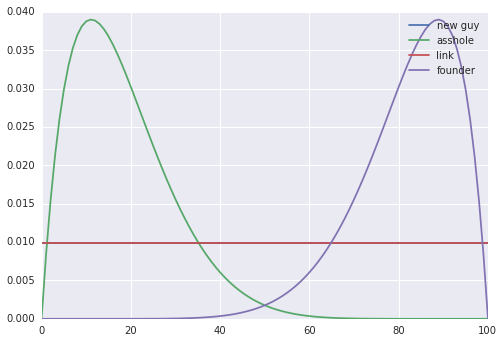

In [278]:
plot({"founder": founder, "asshole": asshole, "new guy": new_redditor, "link": link})

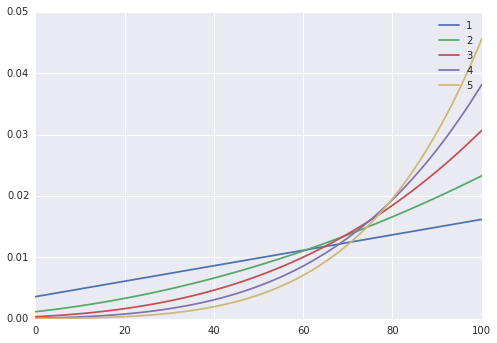

In [296]:
# Let's see what happens when a bunch of founders think a link is good
evolution_of_link = {}
link = Link()
for i in range(5):
    _, link = update('up', Redditor(9,2), link)
    evolution_of_link[i+1]=thinkbayes2.Pmf(link)
plot(evolution_of_link)
# Probability of quality of the link skews towards good

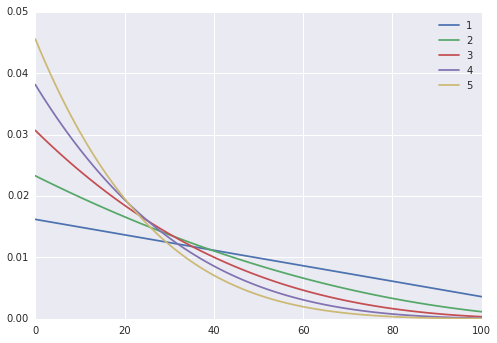

In [297]:
# Let's see what happens when a bunch of a-holes think a link is good
evolution_of_link = {}
link = Link()
for i in range(5):
    _, link = update('up', Redditor(2,9), link)
    evolution_of_link[i+1]=thinkbayes2.Pmf(link)
plot(evolution_of_link)
# Probability of quality of the link skews towards bad

In [308]:
# Now let's see what happens when a founder down votes a bunch of bad links
links = {}
evolution_of_founder = {}
founder = Redditor(9,2)
for i in range(5):
    alpha = random.randint(1,5)
    beta = random.randint(alpha,10) # Creating bad links randomly with alpha < beta
    founder, link = update('down', founder, Link(alpha, beta))
    links["link {}".format(i+1)]=thinkbayes2.Pmf(link)
    evolution_of_founder["vote {}".format(i+1)]=thinkbayes2.Pmf(founder)

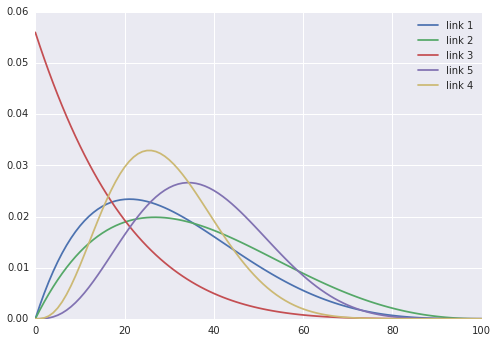

In [309]:
# Here we see the randomly bad links
plot(links)

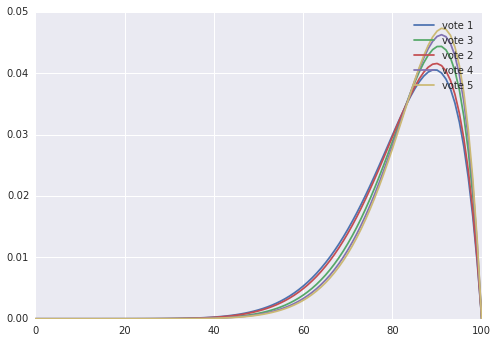

In [310]:
# As the founder, trustworthy person, downvotes a bad link, it solidifies its standing as a founder.
plot(evolution_of_founder)

In [313]:
DataFrame({key: Summarize(val) for key, val in evolution_of_founder.items()})

,vote 1,vote 2,vote 3,vote 4,vote 5
5th %ile,62,63,65,66,67
95th %ile,96,97,97,97,97
CI,"(62.0, 96.0)","(63.0, 97.0)","(65.0, 97.0)","(66.0, 97.0)","(67.0, 97.0)"
MLE,89,90,91,91,91
Mean,82.48537,82.89825,83.94939,84.56558,84.89836
Median,84,85,86,86,87
prob 50,0.001451477,0.001284618,0.0008895751,0.0007053687,0.000619689
